# Задание 4
## Цель задания
* Исследование скрытых характеристик сигналов электроэнцефалографии  
## Ключевой навык
* Расчет спектральной плотности, вейвлет преобразование
## Датасет
* Необходимо загрузить датасет, расположенный по адресу: https://zenodo.org/records/2547147#.Y7eU5uxBwlI
## Задание
1.	Выберите любой файл в формате EDF. 
2.	По аннотации из датасета определите, где в записи ЭЭГ указан приступ. Постройте график временной зависимости ЭЭГ в момент приступа (выбирайте диапазон времени и масштаб так, чтобы было наглядно). 
3.	Сделайте усреднение всех каналов ЭЭГ в один (нужно сложить все каналы и разделить на их количество).
4.	Удалите из сигнала все частоты выше 60 Гц. Для этого преобразованного сигнала:
    * постройте спектрограмму сигнала;
    * постройте вейвлет-преобразование (скейлограмму).


In [50]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.signal import butter, lfilter
from scipy.signal import spectrogram

In [10]:
# Загружаем файл
raw = mne.io.read_raw_edf("eeg1.edf", preload=True)
raw.info

Extracting EDF parameters from /Users/timerlan/Desktop/StudyProjects/4/PPA/eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1790207  =      0.000 ...  6992.996 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-REF, EEG Fp2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2011-11-11 11:11:11 UTC
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>

In [12]:
# Получаем временные метки
data, times = raw.get_data(return_times=True)
sfreq = raw.info['sfreq']  # частота дискретизации в Гц
print(f"Форма данных: {data.shape}, Частота дискретизации: {sfreq} Гц")

Форма данных: (21, 1790208), Частота дискретизации: 256.0 Гц


In [92]:
# Определяем где указан приступ
annotations_df = pd.read_csv("annotations_2017_A.csv", header=0)
seizure_indices = annotations_df.index[annotations_df["1"] == 1].tolist()  # Индексы приступов
seizure_indices

[103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 741,
 742,
 743,
 744,
 745,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754

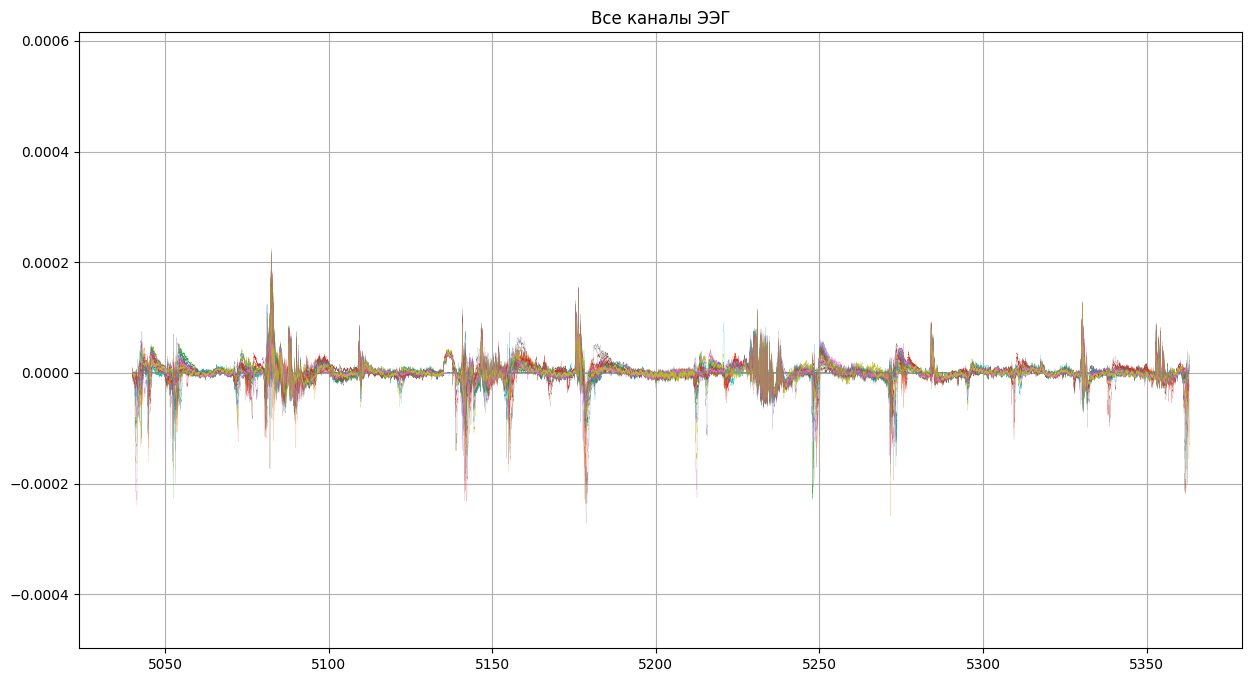

In [110]:
# Диапазон приступа 5140-5263
t_index_begin = np.where(times > (5140-100))[0][0]
t_index_end = np.where(times > (5263+100))[0][0]
t = times[t_index_begin:t_index_end]

# Границы по амплитуде для всех каналов в этом диапазоне
y_min = data[:, t_index_begin:t_index_end].min()
y_max = data[:, t_index_begin:t_index_end].max()

plt.figure(figsize=(15, 8))

for i in range(len(raw.ch_names)-2):
    plt.plot(t, data[i, t_index_begin:t_index_end], linewidth=0.1)

plt.ylim(y_min, y_max)
plt.title('Все каналы ЭЭГ')
plt.grid(True)
plt.show()

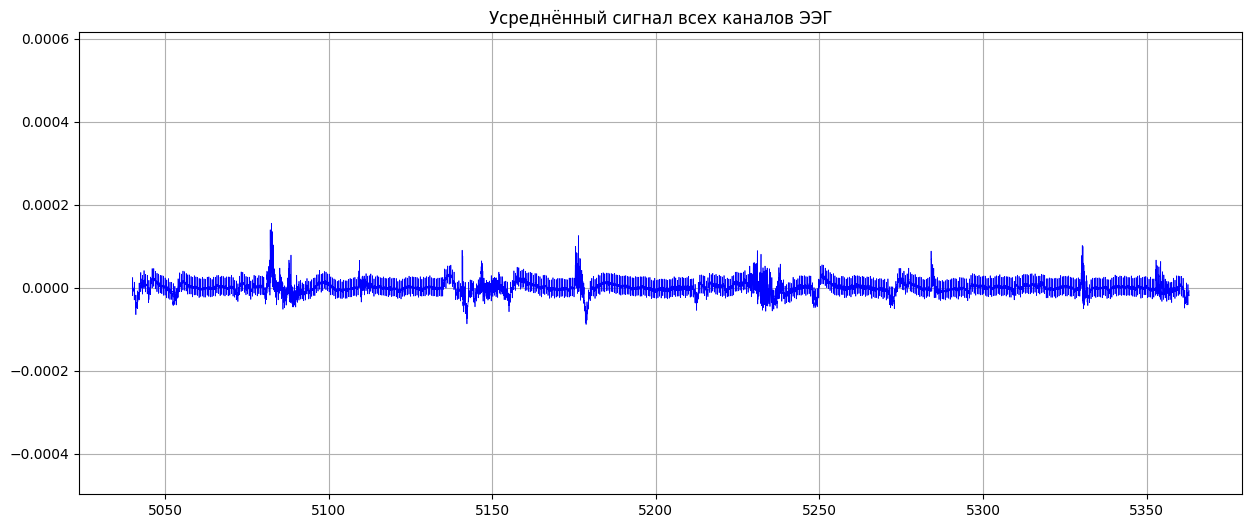

In [96]:
# Усредненный сигнал
avg_signal = data[:, t_index_begin:t_index_end].mean(axis=0)
plt.figure(figsize=(15, 6))
plt.plot(t, avg_signal, linewidth=0.5, color='blue')
plt.ylim(y_min, y_max)
plt.title('Усреднённый сигнал всех каналов ЭЭГ')
plt.grid(True)
plt.show()


In [97]:
# Функция для низкочастотного фильтра
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = lfilter(b, a, data)
    return filtered_data

# Применяем фильтрацию для удаления частот выше 60 Гц
filtered_signal = butter_bandpass_filter(avg_signal, 0.5, 60, 256)


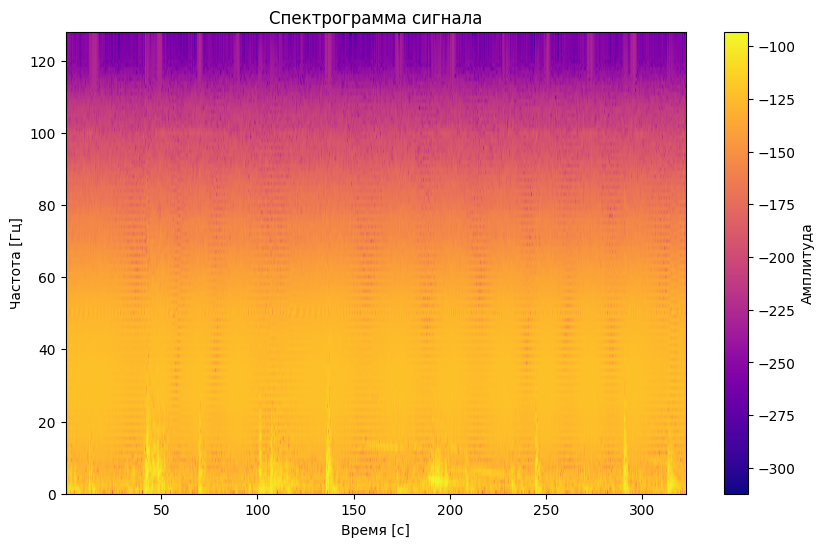

In [99]:
# Строим спектограмму сигнала
plt.figure(figsize=(10, 6))
plt.specgram(filtered_signal, NFFT=256, Fs=sfreq, noverlap=128, cmap='plasma')

plt.title('Спектрограмма сигнала')
plt.ylabel('Частота [Гц]')
plt.xlabel('Время [с]')
plt.colorbar(label='Амплитуда')
plt.show()

/Users/timerlan/Desktop/StudyProjects/4/PPA/.venv/lib/python3.9/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


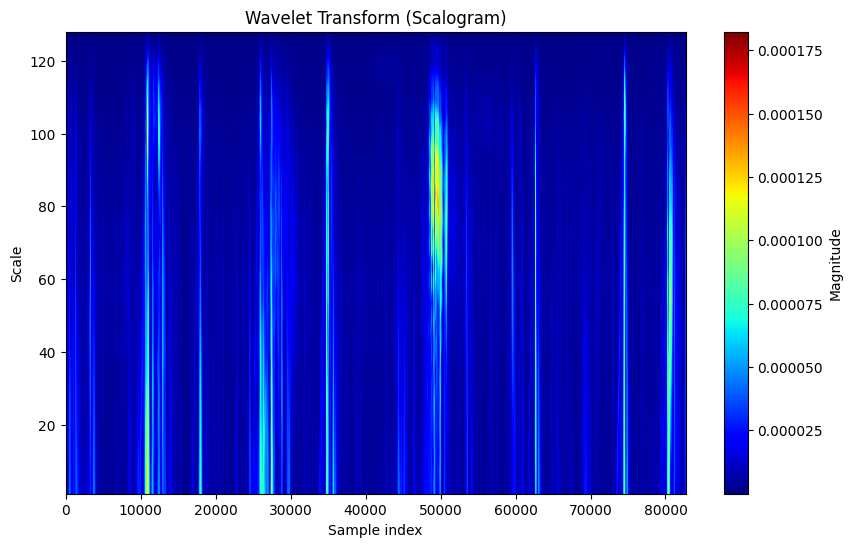

In [100]:
# Выбор вейвлета
wavelet = 'cmor'

# Применение вейвлет-преобразования
coeffs, freqs = pywt.cwt(filtered_signal, np.arange(1, 128), wavelet)

# Построение скейлограммы
plt.figure(figsize=(10, 6))
plt.imshow(abs(coeffs), aspect='auto', extent=[0, len(filtered_signal), 1, 128], cmap='jet')
plt.title('Wavelet Transform (Scalogram)')
plt.ylabel('Scale')
plt.xlabel('Sample index')
plt.colorbar(label='Magnitude')
plt.show()